# **Spiking Recurrent Neural Network (SRNN) for Memtransistor Crossbar Array Simulation**
### **Neuron**
A neuron should be able to change its membrane voltage under different rules, and be fired when current membrane voltage exceed the threshold voltage. Once been fired, the membrane voltage should return to 0. The only difference between the three types of neuron should be the voltage changing mechanism and the rest part should be the same.

    - (DONE, but need debugging) Integrate-and-fire (IF) neuron
    - (DONE, but need debugging) Leaky integrate-and-fire (LIF) neuron
    - (DONE, but need debugging) Adaptive leaky integrate-and-fire (ALIF) neuron
### **Weight Update methods**
For the first 2 methods, i.e., BP and BPTT, the only parameters need to be specified is the loss function and the trainable variables, then optimizer from tensorflow can be applied and get the optimal weights. For STDP, there're a lot of rethinks need to be done.

    - (DONE, but need debugging) Back propagation through time (BPTT) for RNN
    - (Done, but need debugging) Spike timing depedent plasticity (STDP)

### **Model**
    - (TODO) feed-foward (include STDP weight update)
    - (TODO) Back propagation (include BPTT)
    - (TODO) train
    - (TODO) predict (based on feed-forward)

### Part 1 - **Layers.py**
A py file that contains three kinds of recurrent/normal layer as objects.

    - Integrate-and-fire (IF) layer
        - Normal IF layer
        - Recurrent IF layer
    - Leaky integrate-and-fire (LIF) layer (Should contain arbitrary number of IF as well)
        - Normal LIF layer
        - Recurrent LIF layer
    - Adaptive leaky integrate-and-fire (ALIF) layer (Should contain arbitrary number of IF, and LIF neuron as well)
        - Normal ALIF layer
        - Recurrent ALIF layer

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
from collections import namedtuple
from toolbox.tensorflow_einsums.einsum_re_written import einsum_bi_ijk_to_bjk
from toolbox.tensorflow_utils import tf_roll

**Some utility functions**

In [ ]:
# Calculate the gradient for BPTT to optimize
def SpikeFunction(v_scaled, dampening_factor):
    z_ = tf.math.greater(v_scaled, 0.) # returns the truth/flase value of (x > y) element-wise.
    z_ = tf.cast(z_, dtype=tf.float32) # cast z to data type of float32, i.e., true - 1.0, false - 0.0

    def grad(dy): 
        # calculate the gradient for BPTT
        dE_dz = dy # E - error
        dz_dv_scaled = tf.math.maximum(1 - tf.abs(v_scaled), 0) # pseudo-derivative
        dz_dv_scaled *= dampening_factor # dampening_factor = 0.3 for sequantial MNIST in NIPS 2018 

        dE_dv_scaled = dE_dz * dz_dv_scaled

        return [dE_dv_scaled,
                tf.zeros_like(dampening_factor)] 

    return tf.identity(z_, name="SpikeFunction"), grad

def weight_matrix_with_delay_dimension(w, d, n_delay):
    """
    Generate the tensor of shape n_in x n_out x n_delay that represents the synaptic weights with the right delays.

    :param w: synaptic weight value, float tensor of shape (n_in x n_out)
    :param d: delay number, int tensor of shape (n_in x n_out)
    :param n_delay: number of possible delays
    :return:
    """
    with tf.name_scope('WeightDelayer'):
        w_d_list = []
        for kd in range(n_delay):
            mask = tf.equal(d, kd)
            w_d = tf.where(condition=mask, x=w, y=tf.zeros_like(w))
            w_d_list.append(w_d)

        delay_axis = len(d.shape)
        WD = tf.stack(w_d_list, axis=delay_axis)

    return WD

In [49]:
Cell = tf.keras.layers.Layer

# integrate-and-fire neuron layer
class IF(Cell):
    def __init__(self, n, type, n_in = None, thr = 0.03, dt = 1.0, n_ref=2, 
        n_delay = 1, dampening_factor=0.3, injected_noise_current=0., v0 = 0.01, w0 = 0.5):
        '''
        type: input/hidden/output
        '''
        self.n = n # number of neuron in this layer
        self.n_in = n_in
        self.thr = thr
        self.dt = dt
        self.n_ref = n_ref
        self.n_delay = n_delay
        self.dampening_factor = dampening_factor
        self.injected_noise_current = injected_noise_current # can be used to simulate the device noise/variation
        assert (v0 < self.thr), "Static voltage should be smaller the threshold!"
        self.v0 = v0
        self.v = self.v0 * np.ones(self.n) # self.v - an array of # self.n that contain the membrane voltage of this layer
        self.z = np.zeros(self.n) # self.z - an array of # self.n that contain possible spikes of this layer
        self.ref_time = np.zeros(self.n)
        self.ref_tag = np.zeros(self.n) # defualt is not in refractory state
        

        if type == 'input':
            pass
        elif type == 'hidden' or 'output':
           self.W_in = tf.Variable(w0*np.ones(self.n_in, self.n))
           self.n_in = n_in
        else:
            raise TypeError("Type should be among input/hidden/output!")

        self.type = type
    

    def dynamic(self, z_pre):
        """
        Function that generate the next spike and voltage tensor for given cell state.
        :param z_pre: spike train from previous layer of neuron/inputs 
        :param 
        :param 
        :return: current v, z
        """
        # define the current 
        if self.type == 'input':
            current = z_pre
        elif self.type == 'hidden' or self.type == 'output':
            current = np.matmul(self.W_in, z_pre)

        # add random noise to current
        if self.injected_noise_current > 0:
            if self.type == 'input':
                current = current + tf.random.normal(shape=self.n, stddev=self.injected_noise_current)
            elif self.type == 'hidden' or self.type == 'output':
                current = current + tf.random.normal(shape=(self.n_in, self.n), stddev=self.injected_noise_current)
        
            
        # update the voltage and spike of this layer
        for i in range(len(self.v)): # for a certain neuron in this layer

            # judge whether to update the voltage or not
            if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                self.ref_time[i] += 1
                self.v[i] = self.v0
            elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                self.ref_tag[i] = 0
                self.ref_time[i] = 0
                self.v[i] = self.v0
            else:
                self.v[i] = self.v[i] + current[i]
            
            # judge if emit spike or not
            if self.v[i] > self.thr:
                self.z[i] = 1 # emit spike 
                self.ref_time[i] += 1 # add timer to count the reference time
                self.ref_tag[i] = 1
            else:
                self.z[i] = 0

        return self.v, self.z

    def get_current_v(self):
        return self.v

    def get_current_z(self):
        return self.z

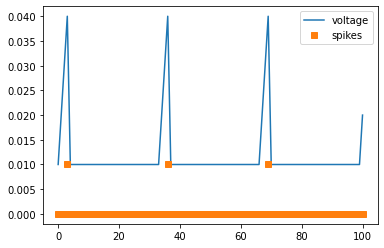

In [87]:
times = np.linspace(0, 100, 101)
IF_trial = IF(10, 'input', n_ref=30)
z_pres = 0.01*np.ones([len(times), IF_trial.n])
v_history = [IF_trial.v[0]]
z_history = [IF_trial.z[0]]
for i in range(len(times)-1):
    IF_trial.dynamic(z_pres[i])
    #print(IF_trial.z[0])
    v_history.append(IF_trial.v[0])
    z_history.append(IF_trial.z[0])
    

plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
#plt.xlim(0, 20)
plt.legend()
plt.show()

In [105]:
#　leaky integrate-and-fire neuron layer
class LIF(IF):
    def __init__(self, n, type, n_in = None, thr = 0.03, dt = 1.0, n_ref=0, tau_v = 20,
                n_delay = 1, dampening_factor=0.3, injected_noise_current=0., v0 = 0.01):
        super(LIF, self).__init__(n = n, type = type, n_in = n_in, thr = thr, dt = dt, n_ref = n_ref, 
                                 n_delay = n_delay, dampening_factor = dampening_factor, 
                                 injected_noise_current = injected_noise_current, v0 = v0)
        self.tau_v = tau_v
        self.alpha = np.exp(-self.dt/self.tau_v)
        
    def dynamic(self, z_pre):
        """
        Function that generate the next spike and voltage tensor for given cell state.
        :param z_pre: spike train from previous layer of neuron/inputs 
        :param 
        :param 
        :return: current v, z
        """
        # define the current 
        if self.type == 'input':
            current = z_pre
            #print(current)
        elif self.type == 'hidden' or self.type == 'output':
            current = np.matmul(self.W_in, z_pre)

        # add random noise to current
        if self.injected_noise_current > 0:
            if self.type == 'input':
                current = current + tf.random.normal(shape=self.n, stddev=self.injected_noise_current)
            elif self.type == 'hidden' or self.type == 'output':
                current = current + tf.random.normal(shape=(self.n_in, self.n), stddev=self.injected_noise_current)
        
            
        # update the voltage and spike of this layer
        for i in range(len(self.v)): # for a certain neuron in this layer

            # judge whether to update the voltage or not
            if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                self.ref_time[i] += 1
                self.v[i] = self.v0
            elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                self.ref_tag[i] = 0
                self.ref_time[i] = 0
                self.v[i] = self.v0
            else:
                self.v[i] = self.alpha * self.v[i] + (1-self.alpha)*current[i]
                #print(self.v[i])
            
            # judge if emit spike or not
            if self.v[i] > self.thr:
                self.z[i] = 1 # emit spike 
                self.ref_time[i] += 1 # add timer to count the reference time
                self.ref_tag[i] = 1
            else:
                self.z[i] = 0

        return self.v, self.z


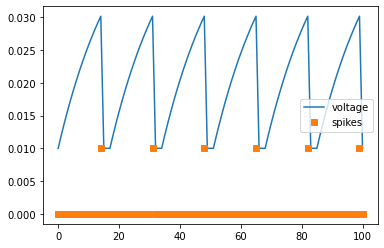

In [112]:
times = np.linspace(0, 100, 101)
LIF_trial = LIF(n=10, type='input', n_ref=3)
z_pres = 0.05*np.ones([len(times), LIF_trial.n])
v_history = [LIF_trial.v[0]]
z_history = [LIF_trial.z[0]]
for i in range(len(times)-1):
    LIF_trial.dynamic(z_pres[i])
    #print(LIF_trial.v)
    v_history.append(LIF_trial.v[0])
    z_history.append(LIF_trial.z[0])

plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
#plt.xlim(0, 20)
plt.legend()
plt.show()

In [165]:
#　leaky integrate-and-fire neuron layer
class ALIF(LIF):
    def __init__(self, n, type, n_in = None, thr = 0.03, dt = 1.0, n_ref=0, tau_v = 20, tau_a = 70, 
                n_delay = 1, dampening_factor=0.3, injected_noise_current=0., v0 = 0.01, beta=1.8):
        super(ALIF, self).__init__(n = n, type = type, n_in = n_in, thr = thr, dt = dt, n_ref = n_ref, tau_v = tau_v,
                                 n_delay = n_delay, dampening_factor = dampening_factor, 
                                 injected_noise_current = injected_noise_current, v0 = v0)
        self.beta = beta
        self.tau_a = tau_a
        self.rou = np.exp(-self.dt/self.tau_a)
        self.thr_list = self.thr * np.ones(self.n) # a list of threshold
        
        
    def dynamic(self, z_pre):
        """
        Function that generate the next spike and voltage tensor for given cell state.
        :param z_pre: spike train from previous layer of neuron/inputs 
        :param 
        :param 
        :return: current v, z
        """
        # define the current 
        if self.type == 'input':
            current = z_pre
            #print(current)
        elif self.type == 'hidden' or self.type == 'output':
            current = np.matmul(self.W_in, z_pre)

        # add random noise to current
        if self.injected_noise_current > 0:
            if self.type == 'input':
                current = current + tf.random.normal(shape=self.n, stddev=self.injected_noise_current)
            elif self.type == 'hidden' or self.type == 'output':
                current = current + tf.random.normal(shape=(self.n_in, self.n), stddev=self.injected_noise_current)
        
            
        # update the voltage, threshold and spike of this layer
        for i in range(len(self.v)): # for a certain neuron in this layer
            
            # update threshold
            #self.thr_list[i] = self.thr + self.beta*(self.rou*self.thr_list[i]+(1-self.rou)*self.z[i])

            # update voltage - judge whether to update the voltage or not
            if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                self.ref_time[i] += 1
                self.v[i] = self.v0
            elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                self.ref_tag[i] = 0
                self.ref_time[i] = 0
                self.v[i] = self.v0
            else:
                self.v[i] = self.alpha * self.v[i] + (1-self.alpha)*current[i]
            
            # update spike - judge if emit spike or not
            if self.v[i] > self.thr_list[i]:
                self.z[i] = 1 # emit spike 
                self.ref_time[i] += 1 # add timer to count the reference time
                self.ref_tag[i] = 1
            else:
                self.z[i] = 0
            # update threshold
            self.thr_list[i] = self.thr + self.beta*(self.rou*self.thr_list[i]+(1-self.rou)*self.z[i])*self.v0

        return self.v, self.z, self.thr_list


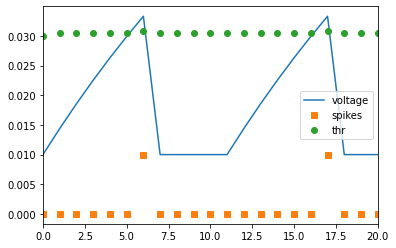

In [167]:
times = np.linspace(0, 100, 101)
ALIF_trial = ALIF(n=10, type='input', n_ref=5, beta=1.8)
z_pres = 0.1*np.ones([len(times), LIF_trial.n])
v_history = [ALIF_trial.v[0]]
z_history = [ALIF_trial.z[0]]
thr_history = [ALIF_trial.thr_list[0]]
for i in range(len(times)-1):
    ALIF_trial.dynamic(z_pres[i])
    #print(ALIF_trial.thr_list[0])
    #print(ALIF_trial.z[0])
    #print(ALIF_trial.v[0])
    v_history.append(ALIF_trial.v[0])
    z_history.append(ALIF_trial.z[0])
    thr_history.append(ALIF_trial.thr_list[0])

plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
plt.plot(times, np.array(thr_history), 'o', label='thr')
plt.xlim(0, 20)
plt.legend()
plt.show()

In [ ]:
Cell_reccurent = tf.keras.layers.AbstractRNNCell

IFStateTuple = namedtuple('IFStateTuple', ('v', 'z', 'i_future_buffer', 'z_buffer'))

@tf.custom_gradient # Decorator to define a function with a custom gradient.

class IF(Cell_reccurent):
    def __init__(self, n_in, n_rec, thr = 0.03, dt = 1.0, n_refractory=0, 
        n_delay = 1, dampening_factor=0.3, dtype=tf.float32, 
        injected_noise_current=0., v0 = 1.):
        '''
            :param n_refractory: number of refractory time steps - refractory time that the neuron cannot be fired again
            :param dtype: data type of the cell tensors
            :param n_delay: number of synaptic delay timestep, the delay range goes from 1 to n_delay time steps
        '''
        if np.isscalar(thr): thr = tf.ones(n_rec, dtype=dtype) * np.mean(thr)
        dt = tf.cast(dt, dtype=dtype)

        self.n_in = n_in
        self.n_rec = n_rec
        self.thr = tf.Variable(thr, dtype=dtype, name="Threshold", trainable=False) 
        self.dt = tf.cast(dt, dtype=dtype)
        self.n_refractory = n_refractory #　number of refractory time steps　—　refractory time that the neuron cannot be fired again
        self.n_delay = n_delay # number of synaptic delay timestep, the delay range goes from 1 to n_delay time steps
        self.dtype = dtype # dtype of neuron tensor
        self.v0 = v0 # initial membrane voltage
        self.dampening_factor = dampening_factor

        self._num_units = self.n_rec
        self.injected_noise_current = injected_noise_current # take device standard deviation into consideration


        # Input weights
        self.w_in_var = tf.Variable(np.random.randn(n_in, n_rec) / np.sqrt(n_in), dtype=dtype, name="InputWeight")
        self.w_in_val = self.w_in_var

        self.w_in_val = self.v0 * self.w_in_val
        # randomize the initial input current weight
        self.w_in_delay = tf.Variable(np.random.randint(self.n_delay, size=n_in * n_rec).reshape(n_in, n_rec),
                                        dtype=tf.int64, name="InDelays", trainable=False) 
        self.W_in = weight_matrix_with_delay_dimension(self.w_in_val, self.w_in_delay, self.n_delay)

        # randomize the initial recurrent current weight
        self.w_rec_var = tf.Variable(np.random.randn(n_rec, n_rec) / np.sqrt(n_rec), dtype=dtype,
                                    name='RecurrentWeight')
        self.w_rec_val = self.w_rec_var

        recurrent_disconnect_mask = np.diag(np.ones(n_rec, dtype=bool))

        self.w_rec_val = self.w_rec_val * self.v0
        self.w_rec_val = tf.where(recurrent_disconnect_mask, tf.zeros_like(self.w_rec_val),
                                    self.w_rec_val)  # Disconnect autotapse
        self.w_rec_delay = tf.Variable(np.random.randint(self.n_delay, size=n_rec * n_rec).reshape(n_rec, n_rec),
                                        dtype=tf.int64, name="RecDelays", trainable=False)
        self.W_rec = weight_matrix_with_delay_dimension(self.w_rec_val, self.w_rec_delay, self.n_delay)

    @property
    def state_size(self):
        return IFStateTuple(v=self.n_rec,
                            z=self.n_rec,
                            i_future_buffer=(self.n_rec, self.n_delay), # create space for future current
                            z_buffer=(self.n_rec, self.n_refractory)) # create space for refractory spike trains

    @property
    def output_size(self):
        return self.n_rec

    def zero_state(self, batch_size, dtype = tf.float32, n_rec=None):
        '''Create the zero state tuple of IF neuron'''
        if n_rec is None: n_rec = self.n_rec

        v0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)
        z0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)

        i_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_delay), dtype=dtype)
        z_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_refractory), dtype=dtype)

        return IFStateTuple(
            v=v0,
            z=z0,
            i_future_buffer=i_buff0,
            z_buffer=z_buff0
        )


    def neuronal_dynamic(self, v, z, z_buffer, i_future_buffer, state=IFStateTuple):
        """
        Function that generate the next spike and voltage tensor for given cell state.
        :param thr - membrane threshold voltage
        :param v - current membrane voltage
        :param z - input spike train from previous layer at time t
        :return: current v, z
        """
        # create current with respect to input current from previous layer and current layer of previous timestep
        add_current = self.W_in * z + self. W_rec * state.z

        # add random noise to current
        if self.injected_noise_current > 0:
            add_current = add_current + tf.random.normal(shape=z.shape, stddev=self.injected_noise_current) 
            
        if thr is None: thr = self.thr
        if n_refractory is None: n_refractory = self.n_refractory

        i_t = i_future_buffer[:, :, 0] + add_current

        I_reset = z * thr * self.dt # thr is fixed for IF/LIF neuron, but changable for ALIF neuron. 

        new_v = v + i_t - I_reset # the membrane voltage at t+dt

        # Spike generation
        v_scaled = (v - thr) / thr

        new_z = SpikeFunction(v_scaled, self.dampening_factor) 

        if n_refractory > 0:
            is_ref = tf.greater(tf.reduce_max(z_buffer[:, :, -n_refractory:], axis=2), 0)
            new_z = tf.where(is_ref, tf.zeros_like(new_z), new_z)

        new_z = new_z * 1 / self.dt

        return new_v, new_z # return the new membrane voltage, and new input spike train

    def __call__(self, inputs, state = IFStateTuple):
        '''Convert the IF neuron to callable object'''
        with tf.name_scope('IFcall'):
            # self.W_in : input current weights
            # self.W_rec : recurrent current weights
            i_future_buffer = state.i_future_buffer + einsum_bi_ijk_to_bjk(inputs, self.W_in) + einsum_bi_ijk_to_bjk(
                state.z, self.W_rec) 

            new_v, new_z = self.neuronal_dynamic(
                v=state.v,
                z=state.z,
                z_buffer=state.z_buffer,
                i_future_buffer=i_future_buffer)

            new_z_buffer = tf_roll(state.z_buffer, new_z, axis=2)
            new_i_future_buffer = tf_roll(i_future_buffer, axis=2)

            new_state = IFStateTuple(v=new_v,
                                     z=new_z,
                                     i_future_buffer=new_i_future_buffer,
                                     z_buffer=new_z_buffer)
        return new_z, new_state

In [ ]:
LIFStateTuple = namedtuple('LIFStateTuple', ('v', 'z', 'i_future_buffer', 'z_buffer'))

class LIF(IF):
    def __init__(self, n_in, n_rec, thr = 0.03, tau = 20., dt = 1., n_refractory=0, 
                n_delay = 1, in_neuron_sign=None, rec_neuron_sign=None, dtype=tf.float32, dampening_factor=0.3,
                injected_noise_current=0., v0=0.01):
        '''
            :param n_refractory: number of refractory time steps - refractory time that the neuron cannot be fired again
            :param dtype: data type of the cell tensors
            :param n_delay: number of synaptic delay timestep, the delay range goes from 1 to n_delay time steps
        '''
        super(LIF, self).__init__(n_in = n_in, n_rec = n_rec, thr = thr, dt = dt, n_refractory = n_refractory, 
                                  n_delay = n_delay, in_neuron_sign = in_neuron_sign, 
                                  rec_neuron_sign = rec_neuron_sign, dtype = dtype, dampening_factor = dampening_factor,
                                  injected_noise_current = injected_noise_current, v0 = v0)

        if np.isscalar(tau): tau = tf.ones(n_rec, dtype=dtype) * np.mean(tau)
        tau = tf.cast(tau, dtype=dtype)
        
        self.tau = tf.Variable(tau, dtype=dtype, name="Tau", trainable=False)
        self._decay = tf.exp(-dt / tau)

    @property
    def state_size(self):
        return LIFStateTuple(v=self.n_rec,
                             z=self.n_rec,
                             i_future_buffer=(self.n_rec, self.n_delay),
                             z_buffer=(self.n_rec, self.n_refractory))

    def zero_state(self, batch_size, dtype, n_rec=None):
        if n_rec is None: n_rec = self.n_rec

        v0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)
        z0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)

        i_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_delay), dtype=dtype)
        z_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_refractory), dtype=dtype)

        return LIFStateTuple(
            v=v0,
            z=z0,
            i_future_buffer=i_buff0,
            z_buffer=z_buff0
        )

    def __call__(self, inputs, state):
        '''Convert the IF neuron to callable object'''
        with tf.name_scope('LIFcall'):
            i_future_buffer = state.i_future_buffer + einsum_bi_ijk_to_bjk(inputs, self.W_in) + einsum_bi_ijk_to_bjk(
                state.z, self.W_rec) # self.W_in and self.W_rec need to consider

            new_v, new_z = self.neuronal_dynamic(
                v=state.v,
                z=state.z,
                z_buffer=state.z_buffer,
                i_future_buffer=i_future_buffer)

            new_z_buffer = tf_roll(state.z_buffer, new_z, axis=2)
            new_i_future_buffer = tf_roll(i_future_buffer, axis=2)

            new_state = LIFStateTuple(v=new_v,
                                      z=new_z,
                                      i_future_buffer=new_i_future_buffer,
                                      z_buffer=new_z_buffer)
        return new_z, new_state

    def neuronal_dynamic(self, v, z, z_buffer, i_future_buffer, thr=None, decay=None, n_refractory=None, add_current=0.):

        if self.injected_noise_current > 0:
            add_current = tf.random.normal(shape=z.shape, stddev=self.injected_noise_current) # add random noise to current

        if thr is None: thr = self.thr
        if decay is None: decay = self._decay
        if n_refractory is None: n_refractory = self.n_refractory

        i_t = i_future_buffer[:, :, 0] + add_current

        I_reset = z * thr * self.dt # thr is fixed for LIF neuron, but changable for ALIF neuron. 

        new_v = decay * v + (1 - decay) * i_t - I_reset # the membrane voltage at t+dt

        # Spike generation
        v_scaled = (v - thr) / thr

        new_z = SpikeFunction(v_scaled, self.dampening_factor) # update the z value

        if n_refractory > 0:
            is_ref = tf.greater(tf.reduce_max(z_buffer[:, :, -n_refractory:], axis=2), 0)
            new_z = tf.where(is_ref, tf.zeros_like(new_z), new_z)

        new_z = new_z * 1 / self.dt

        return new_v, new_z # return the new membrane voltage, and new input spike train

In [ ]:
ALIFStateTuple = namedtuple('ALIFStateTuple', ('v', 'z', 'b', 'i_future_buffer', 'z_buffer'))

class ALIF(LIF):
    def __init__(self, n_in, n_rec, tau=20, thr=0.01,
                 dt=1., n_refractory=0, dtype=tf.float32, n_delay=1,
                 tau_adaptation=200., beta=1.6, dampening_factor=0.3,
                 in_neuron_sign=None, rec_neuron_sign=None, injected_noise_current=0.,
                 v0=0.01):
        """
        Tensorflow cell object that simulates a LIF neuron with an approximation of the spike derivatives.

        :param n_in: number of input neurons
        :param n_rec: number of recurrent neurons
        :param tau: membrane time constant
        :param thr: threshold voltage
        :param dt: time step of the simulation
        :param n_refractory: number of refractory time steps
        :param dtype: data type of the cell tensors
        :param n_delay: number of synaptic delay, the delay range goes from 1 to n_delay time steps
        :param tau_adaptation: adaptation time constant for the threshold voltage
        :param beta: amplitude of adpatation
        :param in_neuron_sign: vector of +1, -1 to specify input neuron signs
        :param rec_neuron_sign: same of recurrent neurons
        :param injected_noise_current: amplitude of current noise
        :param V0: to choose voltage unit, specify the value of V0=1 Volt in the desired unit (example V0=1000 to set voltage in millivolts)
        """

        super(ALIF, self).__init__(n_in=n_in, n_rec=n_rec, tau=tau, thr=thr, dt=dt, n_refractory=n_refractory,
                                   n_delay=n_delay, dampening_factor=dampening_factor, in_neuron_sign=in_neuron_sign,
                                   rec_neuron_sign=rec_neuron_sign,
                                   injected_noise_current=injected_noise_current,
                                   v0=v0, dtype=dtype)

        if tau_adaptation is None: raise ValueError("alpha parameter for adaptive bias must be set")
        if beta is None: raise ValueError("beta parameter for adaptive bias must be set")

        self.tau_adaptation = tf.Variable(tau_adaptation, dtype=dtype, name="TauAdaptation", trainable=False)

        self.beta = tf.Variable(beta, dtype=dtype, name="Beta", trainable=False)
        self.decay_b = np.exp(-dt / tau_adaptation)

    @property
    def output_size(self):
        return [self.n_rec, self.n_rec, self.n_rec]

    @property
    def state_size(self):
        return ALIFStateTuple(v=self.n_rec,
                              z=self.n_rec,
                              b=self.n_rec,
                              i_future_buffer=(self.n_rec, self.n_delay),
                              z_buffer=(self.n_rec, self.n_refractory))

    def zero_state(self, batch_size, dtype, n_rec=None):
        if n_rec is None: n_rec = self.n_rec

        v0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)
        z0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)
        b0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)

        i_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_delay), dtype=dtype)
        z_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_refractory), dtype=dtype)

        return ALIFStateTuple(
            v=v0,
            z=z0,
            b=b0,
            i_future_buffer=i_buff0,
            z_buffer=z_buff0
        )

    def __call__(self, inputs, state):
        with tf.name_scope('ALIFcall'):
            i_future_buffer = state.i_future_buffer + einsum_bi_ijk_to_bjk(inputs, self.W_in) + einsum_bi_ijk_to_bjk(
                state.z, self.W_rec)

            new_b = self.decay_b * state.b + (1. - self.decay_b) * state.z

            thr = self.thr + new_b * self.beta * self.V0

            new_v, new_z = self.neuronal_dynamic(
                v=state.v,
                z=state.z,
                z_buffer=state.z_buffer,
                i_future_buffer=i_future_buffer,
                decay=self._decay,
                thr=thr)

            new_z_buffer = tf_roll(state.z_buffer, new_z, axis=2)
            new_i_future_buffer = tf_roll(i_future_buffer, axis=2)

            new_state = ALIFStateTuple(v=new_v,
                                       z=new_z,
                                       b=new_b,
                                       i_future_buffer=new_i_future_buffer,
                                       z_buffer=new_z_buffer)
        return [new_z, new_v, thr], new_state


    def static_rnn_with_gradient(cell, inputs, state, loss_function, T, verbose=True):
        batch_size = tf.shape(inputs)[0]

        thr_list = []
        state_list = []
        z_list = []
        v_list = []

        if verbose: print('Building forward Graph...', end=' ')
        t0 = time()
        for t in range(T):
            outputs, state = cell(inputs[:, t, :], state)
            z, v, thr = outputs

            z_list.append(z)
            v_list.append(v)
            thr_list.append(thr)
            state_list.append(state)

        zs = tf.stack(z_list, axis=1)
        vs = tf.stack(v_list, axis=1)
        thrs = tf.stack(thr_list, axis=1)
        loss = loss_function(zs)

        de_dz_partial = tf.gradients(loss, zs)[0]
        if de_dz_partial is None:
            de_dz_partial = tf.zeros_like(zs)
            print('Warning: Partial de_dz is None')
        print('Done in {:.2f}s'.format(time() - t0))

        def namedtuple_to_list(state):
            return list(state._asdict().values())

        zero_state_as_list = cell.zero_state(batch_size, tf.float32)
        de_dstate = namedtuple_to_list(cell.zero_state(batch_size, dtype=tf.float32))
        g_list = []
        if verbose: print('Building backward Graph...', end=' ')
        t0 = time()
        for t in np.arange(T)[::-1]:

            # gradient from next state
            if t < T - 1:
                state = namedtuple_to_list(state_list[t])
                next_state = namedtuple_to_list(state_list[t + 1])
                de_dstate = tf.gradients(ys=next_state, xs=state, grad_ys=de_dstate)

                for k_var, de_dvar in enumerate(de_dstate):
                    if de_dvar is None:
                        de_dstate[k_var] = tf.zeros_like(zero_state_as_list[k_var])
                        print('Warning: var {} at time {} is None'.format(k_var, t))

            # add the partial derivative due to current error
            de_dstate[0] = de_dstate[0] + de_dz_partial[:, t]
            g_list.append(de_dstate[0])

        g_list = list(reversed(g_list))

        gs = tf.stack(g_list, axis=1)
        print('Done in {:.2f}s'.format(time() - t0))

        return zs, vs, thrs, gs, state_list[-1]

## Part 2 - **Weight_Update_Methods.py**
A py file that contains all the weight update methods.

    - Back propagation through time (BPTT) for RNN
    - Spike timing depedent plasticity (STDP)

### BPTT

In [ ]:
def static_rnn_with_gradient(cell, inputs, state,  T, loss=tf.keras.losses.SparseCategoricalCrossentropy, verbose=True):
    '''Calculate the gradient'''
    batch_size = tf.shape(inputs)[0]

    thr_list = []
    state_list = []
    z_list = []
    v_list = []

    if verbose: print('Building forward Graph...', end=' ')
    t0 = time()
    for t in range(T):
        outputs, state = cell(inputs[:, t, :], state)
        z, v, thr = outputs

        z_list.append(z)
        v_list.append(v)
        thr_list.append(thr)
        state_list.append(state)

    zs = tf.stack(z_list, axis=1)
    vs = tf.stack(v_list, axis=1)
    thrs = tf.stack(thr_list, axis=1)
    loss = loss(zs)

    de_dz_partial = tf.gradients(loss, zs)[0]
    if de_dz_partial is None:
        de_dz_partial = tf.zeros_like(zs)
        print('Warning: Partial de_dz is None')
    print('Done in {:.2f}s'.format(time() - t0))

    def namedtuple_to_list(state):
        return list(state._asdict().values())

    zero_state_as_list = cell.zero_state(batch_size, tf.float32)
    de_dstate = namedtuple_to_list(cell.zero_state(batch_size, dtype=tf.float32))
    g_list = []
    if verbose: print('Building backward Graph...', end=' ')
    t0 = time()
    for t in np.arange(T)[::-1]:

        # gradient from next state
        if t < T - 1:
            state = namedtuple_to_list(state_list[t])
            next_state = namedtuple_to_list(state_list[t + 1])
            de_dstate = tf.gradients(ys=next_state, xs=state, grad_ys=de_dstate)

            for k_var, de_dvar in enumerate(de_dstate):
                if de_dvar is None:
                    de_dstate[k_var] = tf.zeros_like(zero_state_as_list[k_var])
                    print('Warning: var {} at time {} is None'.format(k_var, t))

        # add the partial derivative due to current error
        de_dstate[0] = de_dstate[0] + de_dz_partial[:, t]
        g_list.append(de_dstate[0])

    g_list = list(reversed(g_list))

    gs = tf.stack(g_list, axis=1)
    print('Done in {:.2f}s'.format(time() - t0))

    return zs, vs, thrs, gs, state_list[-1]

### Modified_STDP

In [ ]:
def Modified_STDP_weight_update(ratio, G_min, G_max, current_weight, 
                       alpha_p, alpha_m, beta_p, beta_m, potentiation = 1):
    
    '''
    Inputs:
        ratio: true_update_ratio/calculated_update_ratio by exponential funcion
        G_min: minimum conductance of a device
        G_max: maximum conductance of a device
        current_weight: current weight matrix
        alpha_p: alpha index for potentiation
        alpha_m: alpha index for depression 
        beta_p: beta index for potentiation
        beta_m: beta index for depression
        t1: fired time of pre-synaptic neuron
        t2: fired time of post-synaptic neuron
    Return:
        updated_weights
    '''
    if potentiation == 1: # for the case of potentiation
        delta_weight = alpha_p * np.exp(-beta_p*(current_weight-G_min)/(G_max-G_min))
        updated_weight = current_weight + delta_weight * ratio

    elif potentiation == 0: # for the case of depression
        delta_weight = -alpha_m * np.exp(-beta_m*(G_max-current_weight)/(G_max-G_min))
        updated_weight = current_weight + delta_weight * ratio
    else:
        raise ValueError("Parameter potentiation must be 0 or 1!")

    return updated_weight

# calculate the change of weight/conductance with respect to z_pre and z_rec
def Modified_update_weight(w_in, z_pre, z_rec, G_min, G_max, alpha_p, alpha_m, beta_p, beta_m, ratios):
    '''For arbitrary spike trains - z_pre and z_rec, update the weight''' 
    assert (len(z_pre) == len(z_rec)), "two input spike trains should have the same length."
    w_in_history = []
    for i in range(len(z_pre)-1):
        if z_pre[i] != 0:
            if z_rec[i-1] != 0: #　depression
                w_in = Modified_STDP_weight_update(ratios[i], G_min, G_max, w_in, alpha_p, alpha_m, beta_p, beta_m, 0)
            elif z_rec[i+1] != 0: # potentiation
                w_in = Modified_STDP_weight_update(ratios[i], G_min, G_max, w_in, alpha_p, alpha_m, beta_p, beta_m, 1)
        w_in_history.append(w_in)
    return w_in_history


### Model

In [ ]:
RNN = tf.keras.layers.RNN()

class Spiking_Layer(RNN):
    def __init__(self, Cell, return_sequences=False, return_state=False):
        '''
            :param Cell: type of recurrent cell, either ALIF or LIF.
            :param return_sequences
            :param return_state
        '''
        self.Cell = Cell
        self.return_sequences = return_sequences
        self.return_state = return_state

    def get_shape():
        return Cell.shape()

    
        

class Spiking_model(tf.keras.Model):
    def __init__(self, input, hidden, output, G_min, G_max, ratios,
                       alpha_p, alpha_m, beta_p, beta_m, weights_init = 0.5):
        super().__init__()
        # model structures
        self.input = input
        self.hidden = hidden
        self.output = output

        # STDP parameters
        self.G_min = G_min
        self.G_max = G_max
        self.alpha_p = alpha_p
        self.alpha_m = alpha_m
        self.beta_p = beta_p
        self.beta_m = beta_m
        self.ratios = ratios

        # initial weights
        self.weights = [weights_init * np.ones([input.get_shape(), hidden.get_shape()]),
                        weights_init * np.ones([hidden.get_shape(), input.get_shape()])]
      

    def call(self, x, STDP=True):
        '''feed-forward function for the model'''
        hidden_input_val = self.input(x)
        if STDP==True:
            self.weights = Modified_STDP_weight_update(self.ratios, self.G_min, self.G_max, self.weights, 
                       self.alpha_p, self.alpha_m, self.beta_p, self.beta_m)
        
        output_input_val = self.output(hidden_input_val)
        return self.output(output_input_val)

    def calculate_loss(self, x, y_true, loss_func):
        y_pred = self.call(x, STDO=True)
        return loss_func(y_pred, y_true)

    def fit(self, x, y_true, loss_func):
        # calculate the loss
        loss = self.calculate_loss(x, y_true, loss_func)

        # calculate the derivative

        # Conduct BPTT through time
        




    @property
    def state_size(self):
        return IFStateTuple(v=self.n_rec,
                            z=self.n_rec,
                            i_future_buffer=(self.n_rec, self.n_delay), # create space for future current
                            z_buffer=(self.n_rec, self.n_refractory)) # create space for refractory spike trains

    @property
    def output_size(self):
        return self.n_rec

    def zero_state(self, batch_size, dtype = tf.float32, n_rec=None):
        '''Create the zero state tuple of IF neuron'''
        if n_rec is None: n_rec = self.n_rec

        v0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)
        z0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)

        i_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_delay), dtype=dtype)
        z_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_refractory), dtype=dtype)

        return IFStateTuple(
            v=v0,
            z=z0,
            i_future_buffer=i_buff0,
            z_buffer=z_buff0
        )
    

# **Main function for sMNIST**

- (Partially Done) Define some constants
- (Done) Generate spike trains from images
- (TODO) Define the model
- (TODO) Fit the model by STDP and BPTT
- (TODO) Calculate the accuracy

In [ ]:
import tensorflow as tf
import numpy as np
import pickle, gzip


# (TODO) - Step 1: define some constants

# Constants for the model
input_n = tf.constant(80)
input_exitatory_n = tf.constant(60)
input_inhibitary_n = tf.constant(20)
hidden_n = tf.constant(220)
hidden_LIF_n = tf.constant(120)
hidden_ALIF_n = hidden_n - hidden_LIF_n
output_n = tf.constant(10)
print("Please specify the type of model (ALIF/LIF).")
model = tf.string(str(input(" Model: ")))

# Constants for training and testing
print("Please specify the constants for STDP weight update.")

training_size = tf.constant(int(input(" Training size: ")))
test_size = tf.constant(int(input(" Test size: ")))
dampening_factor = 0.3 # dampening factor for pseudo gradient

# Constants for STDP
print("Please specify the constants for STDP weight update.")

# potentiation
alpha_p = tf.constant(float(input(" alpha_p: ")))
beta_p = tf.constant(float(input(" beta_p: ")))

# depression
alpha_m = tf.constant(float(input(" alpha_m: ")))
beta_m = tf.constant(float(input(" beta_m: ")))

# device parameters
G_max = tf.constant(float(input(" G_max: ")))
G_min = tf.constant(float(input(" G_min: ")))

# time constants
t0 = 0 # initial time as 0
dt = 1 # timestep from  NIPS 2018

# ALIF/LIF neuron constants
tau_v = 20 # time constant for voltage changing from NIPS 2018
tau_a = 700 # time constant for adaptive threshold from NIPS 2018
thr = 0.1 # baseline threshold of ALIF neuron/threshold of LIF neuron
beta = 1.8 # Scaling constant of the adaptive threshold
n_delay = 10 # maximum synaptic delay
n_ref = 5 # number of refractory steps
v0 = 0.0 # membrane voltage at 0 timestep
dtype = tf.float32 # datatype of parameters inside neurons

In [ ]:
# Step 2: read in the MNIST images and convert them to spike trains
def load_training_set(mnist_directory, training_size):
    """
    Load the MNIST digits for training. Shuffles them as well.

    Inputs: 
        mnist_directory - string: the directory to store MNIST dataset
        training_size - int : the size of training size
    Return:
        training_set - np.array: training_set of randomly selected images from MNIST with size of training_size
    """
    # Sanity checks
    assert(type(mnist_directory) == str), "Parameter mnist_directory must be a string!"
    assert(type(training_size) == int), "Parameter training_size must be an int!"
    assert(training_size >=0 and training_size <= 60000), "Parameter training_size must >= 0 and <= 60000!"

    print("Loading MNIST for training (randomized)...")
    
    # Update global training_set variable
    global training_set
    
    # Open MNIST pickle package
    f = gzip.open(mnist_directory, 'rb')
    
    # load sets using pickle
    # encoding necessary since pickle file was created in python 2.7
    train, valid, _ = pickle.load(f,encoding='latin1')
    
    # split up into corresponding sets
    [training_set, _] = train
    [validation_set, _] = valid
    
    # update training set
    training_set = np.concatenate((training_set, validation_set))
    
    # close MNIST file
    f.close()
    
    # randomize loaded MNIST set
    np.random.shuffle(training_set)

    #random_index = np.random.choice(training_set)
    random_index = np.random.choice(training_set.shape[0],training_size,replace=False)
    training_set = training_set[random_index]
    
    print("Done!")

    return training_set


# Reference repo: 
# https://github.com/intel-nrc-ecosystem/models/blob/master/nxsdk_modules_ncl/lsnn/tutorials/smnist_tutorial.ipynb
# Part: Encoding the images into spikes
# spike encoding example
def find_onset_offset(y, threshold):
    """
    Given the input signal y with samples,
    find the indices where y increases and descreases through the value threshold.
    Return stacked binary arrays of shape y indicating onset and offset threshold crossings.
    y must be 1-D numpy arrays.
    """
    # Sanity check
    #assert (len(np.array(threshold)) == 1), "The length of threshold should be 1!"

    if threshold == 255:
        equal = y == threshold
        transition_touch = np.where(equal)[0]
        touch_spikes = np.zeros_like(y)
        touch_spikes[transition_touch] = 1
        return np.expand_dims(touch_spikes, axis=0)
    else:
        # Find where y crosses the threshold (increasing).
        lower = y < threshold
        higher = y >= threshold
        transition_onset = np.where(lower[:-1] & higher[1:])[0]
        transition_offset = np.where(higher[:-1] & lower[1:])[0]
        onset_spikes = np.zeros_like(y)
        offset_spikes = np.zeros_like(y)
        onset_spikes[transition_onset] = 1
        offset_spikes[transition_offset] = 1

    return np.stack((onset_spikes, offset_spikes))


def generate_spike_train_from_image(image, n_inputs = 80):
    """Generate spike trains from an given image.
    Input:
        image: a numpy array that represent pixels of an image
        n_inputs: number of input neurons.
        n_thresholds: number of thresholds for the input layer.
                      should be around half of the number of input neurons. 
    Output
        spike_train_image: spike train of a given image
    """
    # Sanity check
    assert(type(image) == np.ndarray), "Parameter image should be a np.array!"
    assert(type(n_inputs) == int), "Parameter n_inputs should be an int!"

    # turn the image into a 1D array
    image = image.reshape(-1, 1)

    thresholds = np.linspace(0, 255, n_inputs // 2)

    spike_train_image = []
    for pixel in image:  # shape img = (784)
        Sspikes = None
        for thr in thresholds:
            if Sspikes is not None:
                Sspikes = np.concatenate((Sspikes, find_onset_offset(pixel, thr)))
            else:
                Sspikes = find_onset_offset(pixel, thr)
        Sspikes = np.array(Sspikes)  # shape Sspikes = (31, 784)
        Sspikes = np.swapaxes(Sspikes, 0, 1)
        spike_train_image.append(Sspikes)
    spike_train_image = np.array(spike_train_image)
    # add output cue neuron, and expand time for two image rows (2*28)
    out_cue_duration = 2*28 # 56 timesptes to mark the end of encoding an image
    spike_train_image = np.lib.pad(spike_train_image, ((0, 0), (0, out_cue_duration), (0, 1)), 'constant')
    # output cue neuron fires constantly for these additional recall steps
    spike_train_image[:, -out_cue_duration:, -1] = 1

    return spike_train_image

def image_process_pipeline(mnist_directory, training_size):
    training_set = load_training_set(mnist_directory, training_size)
    spike_trains_training_set = []
    for image in training_set:
        spike_trains_training_set.append(generate_spike_train_from_image(image))

    return np.array(spike_trains_training_set)

In [ ]:
# (TODO) - Step 3: define the model

# Define the model
if model == 'LIF': # for LIF model
    beta = np.concatenate([np.zeros(hidden_n)])
    cell = LIF(n_in=input_n, n_rec=hidden_n, thr=thr, tau=tau_v, dt=dt, n_refractory=n_ref, 
               n_delay = n_delay, dampening_factor=dampening_factor, v0 = v0)
elif model == 'ALIF': # for ALIF model
    beta = np.concatenate([np.zeros(hidden_LIF_n), np.ones(hidden_ALIF_n) * beta])
    cell = ALIF(n_in=input_n, n_rec=hidden_n, tau=tau_v, thr=thr,
                 dt=dt, n_refractory=n_ref, dtype=dtype, n_delay=n_delay,
                 tau_adaptation=tau_a, beta=beta, dampening_factor=dampening_factor, v0=v0)
else:
     raise NotImplementedError("Unknown model: " + model)

#input_pixels = tf.compat.v1.placeholder(dtype=tf.float32, shape=(None, None, input_n),
                             # name='InputSpikes')  # MAIN input spike placeholder

#targets = tf.compat.v1.placeholder(dtype=tf.int64, shape=(None,),
 #                        name='Targets')  # Lists of target characters of the recall task

outputs, final_state = tf.keras.layers.RNN(cell, return_sequences=True, return_state=True)

if model == 'ALIF':
    z, v, b = outputs
else:
    z = outputs

# (TODO) - Step 4: fit the model
# (TODO) - Step 5: test and calculate the accuracy  